In [1]:
# ---- run on CPU only (bypass GPU / CUDA handle issues) ----
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # hide GPUs from TF

import tensorflow as tf
print("TF devices:", tf.config.list_physical_devices())  # sanity check


2025-09-15 02:04:33.252129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757919873.277207 1639564 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757919873.284505 1639564 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757919873.303179 1639564 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757919873.303203 1639564 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757919873.303207 1639564 computation_placer.cc:177] computation placer alr

TF devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-09-15 02:04:36.877224: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-09-15 02:04:36.877263: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES=""
2025-09-15 02:04:36.877273: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to an empty string - this hides all GPUs from CUDA
2025-09-15 02:04:36.877279: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-09-15 02:04:36.877287: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: cpsc-nfmartin-1.cropsci.illinois.edu
2025-09-15 02:04:36.877293: I external/

In [2]:
# ========= 0) Imports =========
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# ========= 1) Load + light prep =========
gdf = gpd.read_file("/home/emine2/R121/Wainwright/grid_50_risk_index.shp")  # or .shp, .parquet
# Ensure expected columns exist
req = ['drained_la','excess_ice','ice_wedge_','contaminat','infra_exis','erosion_ex','risk_index','geometry']
missing = [c for c in req if c not in gdf.columns]
assert not missing, f"Missing columns: {missing}"

# Make contaminant OPEN binary and ensure binary cols are ints
gdf = gdf.copy()
gdf['contaminat_open'] = (gdf['contaminat'].astype(str).str.lower() == 'open').astype(int)
gdf['ice_wedge_'] = gdf['ice_wedge_'].astype(int)
gdf['infra_exis'] = gdf['infra_exis'].astype(int)
gdf['erosion_ex'] = gdf['erosion_ex'].astype(int)

# Choose predictors (you can add/remove here)
predictor_cols = ['drained_la','excess_ice','ice_wedge_','contaminat_open','infra_exis','erosion_ex']
target_col     = 'risk_index'

# ========= 2) Rasterize irregular grid to 2D arrays (50 m) =========
# We'll index cells by (row, col) using centroids.
res = 50.0
cent = gdf.geometry.centroid
xs, ys = cent.x.values, cent.y.values

minx, miny, maxx, maxy = gdf.total_bounds
# row 0 at top (maxy), col 0 at left (minx)
cols = np.floor((xs - minx) / res).astype(int)
rows = np.floor((maxy - ys) / res).astype(int)

H = rows.max() + 1
W = cols.max() + 1

def to_raster(colname, fill=np.nan):
    A = np.full((H, W), fill, dtype=float)
    A[rows, cols] = gdf[colname].astype(float).values
    return A

# Build each channel
channels = [to_raster(c) for c in predictor_cols]
Y        = to_raster(target_col)   # risk_index as 2D array

# ========= 3) Normalize predictors (ignore NaNs) =========
def nan_standardize(A):
    mu  = np.nanmean(A)
    std = np.nanstd(A) + 1e-8
    B   = (A - mu) / std
    return np.nan_to_num(B, nan=0.0), (mu, std)

X_list = []
norm_stats = {}
for c, name in zip(channels, predictor_cols):
    B, stats = nan_standardize(c)
    X_list.append(B)
    norm_stats[name] = stats

X = np.stack(X_list, axis=-1)  # (H, W, C)

# Target (keep numeric; don’t standardize unless you prefer)
Y_nan = Y.copy()
mask_valid = ~np.isnan(Y_nan)  # valid target pixels
Y_filled = np.nan_to_num(Y_nan, nan=0.0)[..., None]  # (H, W, 1)

# ========= 4) Pad to multiples of 4 (for pooling/upsampling) =========
def pad_to_multiple(img, mult=4, pad_val=0.0):
    h, w = img.shape[:2]
    pad_h = (mult - h % mult) % mult
    pad_w = (mult - w % mult) % mult
    if img.ndim == 2:
        out = np.pad(img, ((0,pad_h),(0,pad_w)), constant_values=pad_val)
    else:
        out = np.pad(img, ((0,pad_h),(0,pad_w),(0,0)), constant_values=pad_val)
    return out, pad_h, pad_w

X_pad, ph, pw = pad_to_multiple(X, 4, 0.0)
Y_pad, _, _   = pad_to_multiple(Y_filled.squeeze(-1), 4, 0.0)
M_pad, _, _   = pad_to_multiple(mask_valid.astype(float), 4, 0.0)

Y_pad = Y_pad[..., None]         # (Hp, Wp, 1)
M_pad = M_pad[..., None]         # (Hp, Wp, 1)

# Add batch dimension (single scene)
Xb = X_pad[None, ...]            # (1, Hp, Wp, C)
Yb = Y_pad[None, ...]            # (1, Hp, Wp, 1)
Mb = M_pad[None, ...]            # (1, Hp, Wp, 1)

Hp, Wp, C = X_pad.shape

# ========= 5) Tiny encoder–decoder (predict risk only) =========
inp = layers.Input(shape=(Hp, Wp, C), name="x")

# Encoder
x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inp)
x = layers.MaxPooling2D((2,2))(x)               # Hp/2, Wp/2
x = layers.Conv2D(16, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)               # Hp/4, Wp/4

# Decoder
x = layers.Conv2DTranspose(16, (3,3), strides=2, padding="same", activation="relu")(x)  # Hp/2
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding="same", activation="relu")(x)  # Hp
out = layers.Conv2D(1, (3,3), padding="same", activation="linear", name="risk_hat")(x)

model = models.Model(inputs=inp, outputs=out)

# ========= 6) Masked loss (ignore pixels with missing target) =========
mask_const = tf.constant(Mb, dtype=tf.float32)  # shape (1,Hp,Wp,1)

def masked_mse(y_true, y_pred):
    diff2 = tf.square(y_true - y_pred) * mask_const
    num   = tf.reduce_sum(diff2)
    den   = tf.reduce_sum(mask_const) + 1e-8
    return num / den

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=masked_mse)

# ========= 7) Train (very small #epochs for demo) =========
history = model.fit(
    Xb, Yb,
    epochs=30,
    verbose=1
)

# ========= 8) Evaluate on a random hold-out pixel mask =========
# Build 80/20 split over valid pixels (within the padded frame)
rng = np.random.default_rng(42)
valid_idx = np.argwhere(M_pad.squeeze() == 1.0)          # (N, 2)
N = valid_idx.shape[0]
perm = rng.permutation(N)
split = int(0.8 * N)
train_idx, test_idx = valid_idx[perm[:split]], valid_idx[perm[split:]]

# Predict full map
Yhat = model.predict(Xb, verbose=0)[0, ... , 0]          # (Hp, Wp)

# Extract test pixels
yt = Y_pad[..., 0]
test_vals_true = yt[test_idx[:,0], test_idx[:,1]]
test_vals_pred = Yhat[test_idx[:,0], test_idx[:,1]]

mse  = mean_squared_error(test_vals_true, test_vals_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(test_vals_true, test_vals_pred)
r, _ = pearsonr(test_vals_true, test_vals_pred)

print(f"Test RMSE: {rmse:.4f} | MAE: {mae:.4f} | r: {r:.3f}")

# ========= 9) Get unpadded predictions and (optional) write back to GeoDataFrame =========
# Remove padding
Yhat_unpad = Yhat[:Hp-ph if ph>0 else Hp, :Wp-pw if pw>0 else Wp]

# Pull predicted values at your original grid cells
pred_at_cells = Yhat_unpad[rows, cols]
gdf['risk_pred'] = pred_at_cells

# Absolute error where target exists
gdf['risk_abs_err'] = np.abs(gdf[target_col].values - gdf['risk_pred'].values)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2285
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2132
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2015
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1910
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1798
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1673
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1534
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1386
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1239
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.1108
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1011
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0951
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0904
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0846
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0767
Epoch 16/30
1/1 ━━━━━━

In [3]:
model.summary(line_length=90, expand_nested=True)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                 ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ x (InputLayer)                        │ (None, 204, 212, 6)          │               0 │
├───────────────────────────────────────┼──────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                       │ (None, 204, 212, 32)         │           1,760 │
├───────────────────────────────────────┼──────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)          │ (None, 102, 106, 32)         │               0 │
├───────────────────────────────────────┼──────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                     │ (None, 102, 106, 16)         │           4,624 │
├───────────────────────────────────────┼──────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)        │ (None, 51, 53, 16)           │               0 │
├───────────────────────────────────────┼──────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)    │ (None, 102, 106, 16)         │           2,320 │
├───────────────────────────────────────┼──────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose)  │ (None, 204, 212, 32)         │           4,640 │
├───────────────────────────────────────┼──────────────────────────────┼─────────────────┤
│ risk_hat (Conv2D)                     │ (None, 204, 212, 1)          │             289 │
└───────────────────────────────────────┴──────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 13,633 (53.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,268 (106.52 KB)

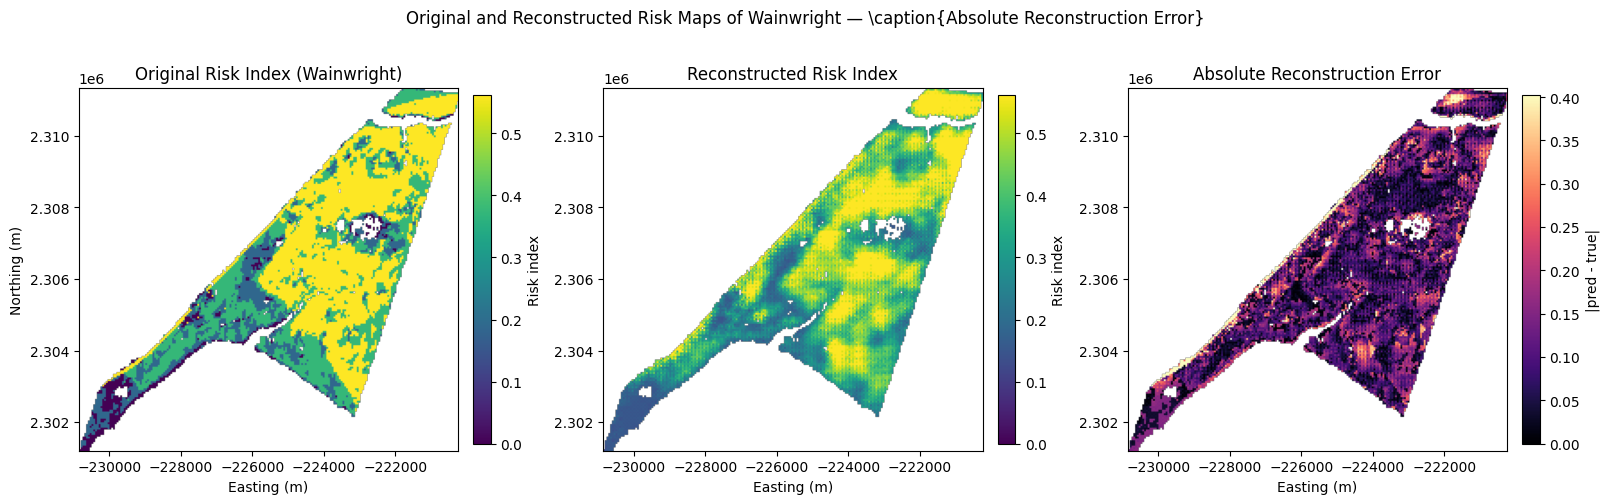

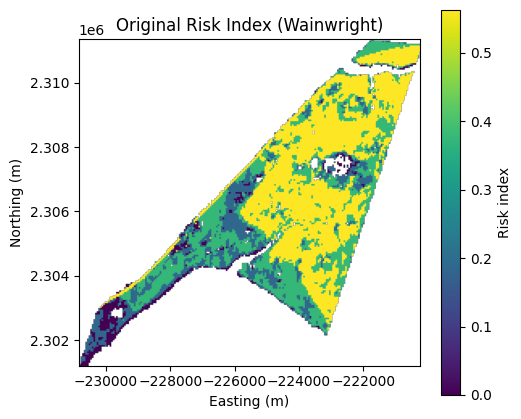

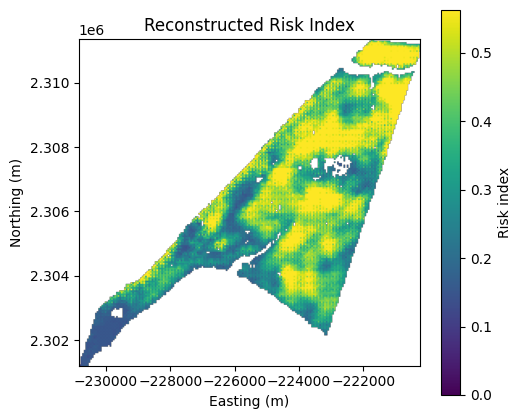

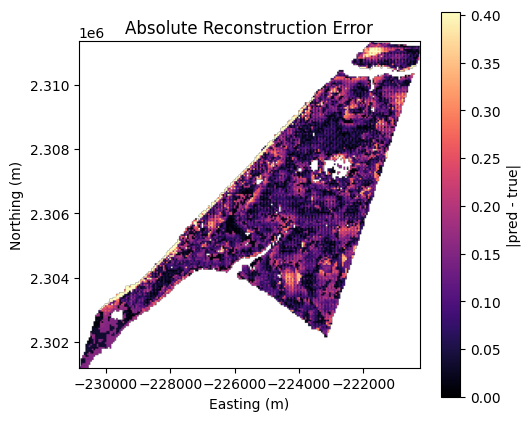

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize



# --- 1) Ensure shapes match + build masked arrays
Y_orig = Y.astype(float)                    # (H, W) original
Y_pred = Yhat_unpad.astype(float)          # (H, W) prediction (unpadded)
M      = mask_valid.astype(bool)           # (H, W)

# mask both to footprint
Y_orig_masked = np.ma.array(Y_orig, mask=~M)
Y_pred_masked = np.ma.array(Y_pred, mask=~M)

# Absolute error where target exists
abs_err = np.abs(Y_pred - Y_orig)
abs_err_masked = np.ma.array(abs_err, mask=~M)

# --- 2) Set geographic extent for imshow (so axes are in meters)
# row 0 was aligned to top (maxy), so use origin='upper'.
extent = [minx, minx + W*res, maxy - H*res, maxy]

# --- 3) Common color scaling for originals (optional but nice)
# Use robust range ignoring NaNs/masked
vmin = np.nanpercentile(Y_orig[M], 2)
vmax = np.nanpercentile(Y_orig[M], 98)
norm_main = Normalize(vmin=vmin, vmax=vmax)

# Error scale (0 to 98th percentile)
emax = np.nanpercentile(abs_err[M], 98)
norm_err = Normalize(vmin=0, vmax=max(emax, 1e-6))



# --- 4) Plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

im0 = axes[0].imshow(Y_orig_masked, origin='upper', extent=extent, norm=norm_main)
axes[0].set_title("Original Risk Index (Wainwright)")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
cbar0.set_label("Risk index")

im1 = axes[1].imshow(Y_pred_masked, origin='upper', extent=extent, norm=norm_main)
axes[1].set_title("Reconstructed Risk Index")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("")
cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
cbar1.set_label("Risk index")

im2 = axes[2].imshow(abs_err_masked, origin='upper', extent=extent, norm=norm_err, cmap="magma")
axes[2].set_title("Absolute Reconstruction Error")
axes[2].set_xlabel("Easting (m)")
axes[2].set_ylabel("")
cbar2 = fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
cbar2.set_label("|pred - true|")

# A caption-like line under the whole figure
fig.suptitle("Original and Reconstructed Risk Maps of Wainwright — \\caption{Absolute Reconstruction Error}", y=1.02, fontsize=12)

# Optional: save individual PNGs and the panel
plt.savefig("wainwright_risk_original_pred_error.png", dpi=300, bbox_inches="tight")

# If you also want separate files:
plt.figure(figsize=(5.5,5))
plt.imshow(Y_orig_masked, origin='upper', extent=extent, norm=norm_main)
plt.title("Original Risk Index (Wainwright)")
plt.colorbar(label="Risk index")
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
plt.savefig("wainwright_risk_original.png", dpi=300, bbox_inches="tight")

plt.figure(figsize=(5.5,5))
plt.imshow(Y_pred_masked, origin='upper', extent=extent, norm=norm_main)
plt.title("Reconstructed Risk Index")
plt.colorbar(label="Risk index")
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
plt.savefig("wainwright_risk_reconstructed.png", dpi=300, bbox_inches="tight")

plt.figure(figsize=(5.5,5))
plt.imshow(abs_err_masked, origin='upper', extent=extent, norm=norm_err, cmap="magma")
plt.title("Absolute Reconstruction Error")
plt.colorbar(label="|pred - true|")
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
plt.savefig("wainwright_risk_abs_error.png", dpi=300, bbox_inches="tight")

plt.show()


In [7]:
# Attach predictions + error back to the original GeoDataFrame
gdf['risk_pred'] = Y_pred[rows, cols]
gdf['risk_abs_err'] = abs_err[rows, cols]

# Save to GeoPackage (recommended) or Shapefile
gdf.to_file("wainwright_risk.gpkg", driver="GPKG")
# gdf.to_file("wainwright_risk.shp")   # shapefile (older, less safe)


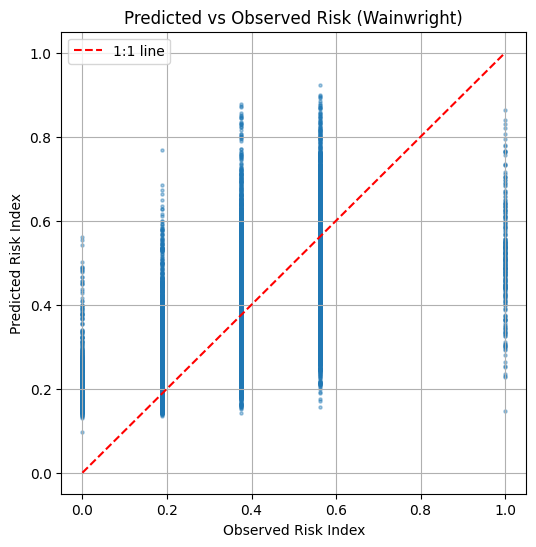

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(Y_orig[M], Y_pred[M], s=5, alpha=0.4)
plt.plot([Y_orig[M].min(), Y_orig[M].max()],
         [Y_orig[M].min(), Y_orig[M].max()],
         'r--', label="1:1 line")
plt.xlabel("Observed Risk Index")
plt.ylabel("Predicted Risk Index")
plt.title("Predicted vs Observed Risk (Wainwright)")
plt.legend()
plt.grid(True)
plt.show()


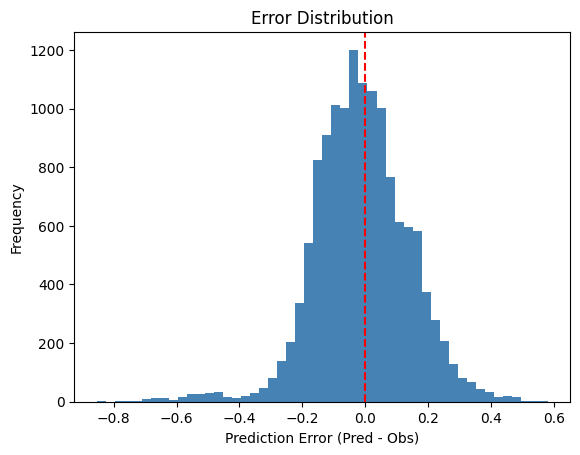

In [9]:
plt.hist((Y_pred[M] - Y_orig[M]).ravel(), bins=50, color='steelblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Prediction Error (Pred - Obs)")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.show()


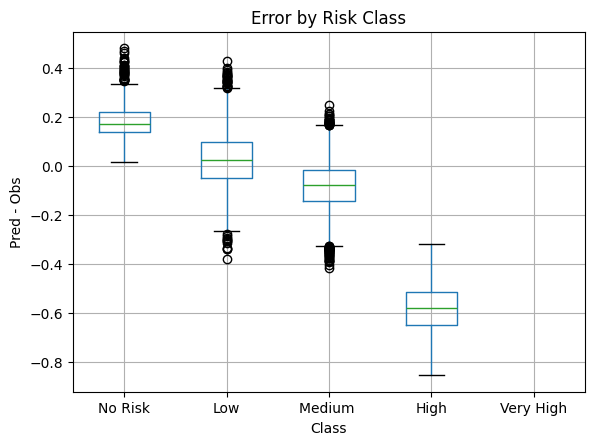

In [19]:
import pandas as pd
risk_classes = pd.cut(Y_orig[M], bins=[-np.inf, 0.187, 0.375, 0.5625, 1.0, np.inf], labels=["No Risk","Low","Medium ","High", "Very High"])
errors = (Y_pred[M] - Y_orig[M])[~np.isnan(Y_orig[M])]
df = pd.DataFrame({"Class": risk_classes, "Error": errors})
df.boxplot(column="Error", by="Class")
plt.title("Error by Risk Class")
plt.suptitle("")
plt.ylabel("Pred - Obs")
plt.show()


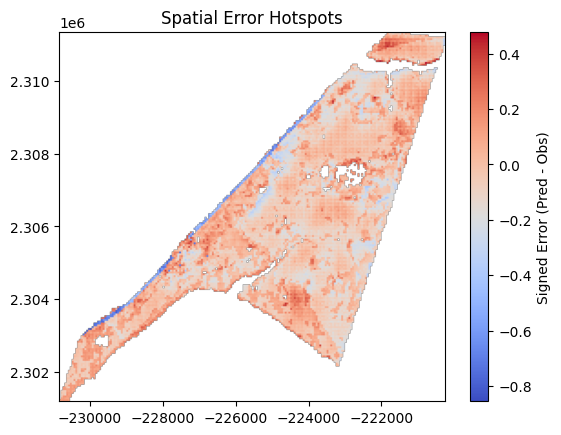

In [9]:
plt.imshow(np.ma.array(Y_pred - Y_orig, mask=~M),
           origin='upper', extent=extent, cmap="coolwarm")
plt.colorbar(label="Signed Error (Pred - Obs)")
plt.title("Spatial Error Hotspots")
plt.show()


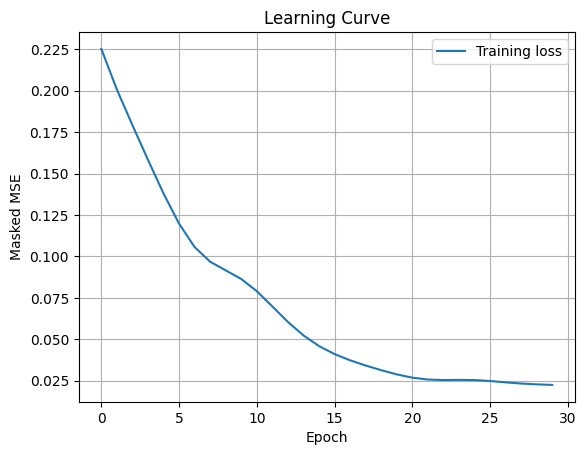

In [12]:
plt.plot(history.history['loss'], label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("Masked MSE")
plt.title("Learning Curve")
plt.grid(True)
plt.legend()
plt.show()


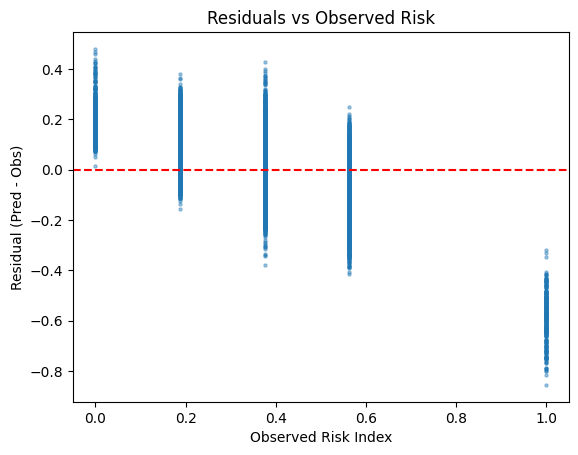

In [11]:
plt.scatter(Y_orig[M], (Y_pred[M] - Y_orig[M]), s=5, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Observed Risk Index")
plt.ylabel("Residual (Pred - Obs)")
plt.title("Residuals vs Observed Risk")
plt.show()
